## Importowanie

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from model_Unet import UNET
from dataset_file import *
from train_file import * 
import matplotlib.pyplot as plt
import torchmetrics

## Dataset

In [2]:
dataset = LipsSet('.', 'images', 'proper_masks')
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

c:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\dataset_file.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  mask = torch.as_tensor([cls_mask_1], dtype=torch.float)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


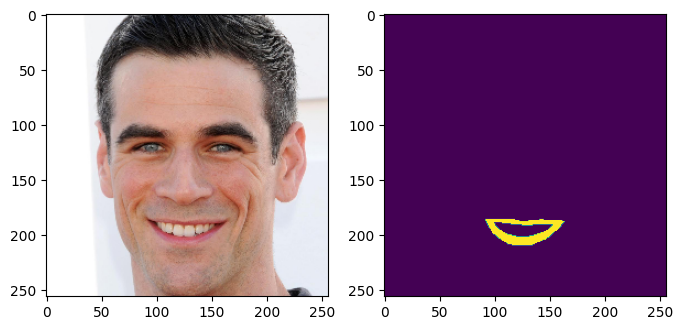

In [3]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

## Trening modelu 

In [4]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
num_epochs = 10

Validation loop: 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Epoch 1/10 - Train loss: 1.0419609427153318, Validation loss: 0.7217281901057641
Best model weights saved at epoch 1 with validation loss: 0.7217


Validation loop: 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Epoch 2/10 - Train loss: 0.39470405376196505, Validation loss: 0.23846277594566345
Best model weights saved at epoch 2 with validation loss: 0.2385


Validation loop: 100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


Epoch 3/10 - Train loss: 0.18954507289524364, Validation loss: 0.23856838654034102


Validation loop: 100%|██████████| 25/25 [02:02<00:00,  4.88s/it]


Epoch 4/10 - Train loss: 0.15659628838375397, Validation loss: 0.1727054317542656
Best model weights saved at epoch 4 with validation loss: 0.1727


Validation loop: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it]


Epoch 5/10 - Train loss: 0.13530890199176052, Validation loss: 0.19217314005796635


Validation loop: 100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


Epoch 6/10 - Train loss: 0.1266895203960868, Validation loss: 0.1328821155294102
Best model weights saved at epoch 6 with validation loss: 0.1329


Validation loop: 100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


Epoch 7/10 - Train loss: 0.11059893850694623, Validation loss: 0.13470531535807567


Validation loop: 100%|██████████| 25/25 [01:45<00:00,  4.21s/it]


Epoch 8/10 - Train loss: 0.10855983573019057, Validation loss: 0.11965145230592794
Best model weights saved at epoch 8 with validation loss: 0.1197


Validation loop: 100%|██████████| 25/25 [01:40<00:00,  4.04s/it]


Epoch 9/10 - Train loss: 0.10052230067196347, Validation loss: 0.11478430721628007
Best model weights saved at epoch 9 with validation loss: 0.1148


Validation loop: 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Epoch 10/10 - Train loss: 0.09771975131710071, Validation loss: 0.11348527542610265
Best model weights saved at epoch 10 with validation loss: 0.1135


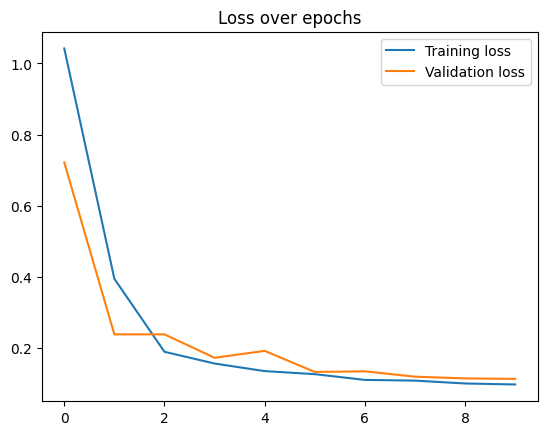

In [ ]:
#train_fn(train_loader, val_loader, model, optimizer, num_epochs, model_path='own_models/model_10_epoch.pth')

## Testowanie modelu

In [7]:
data_iter = iter(test_loader)

images, labels = next(data_iter)

images, labels = images.to(DEVICE), labels.to(DEVICE)

predictions = torch.sigmoid(model(images))


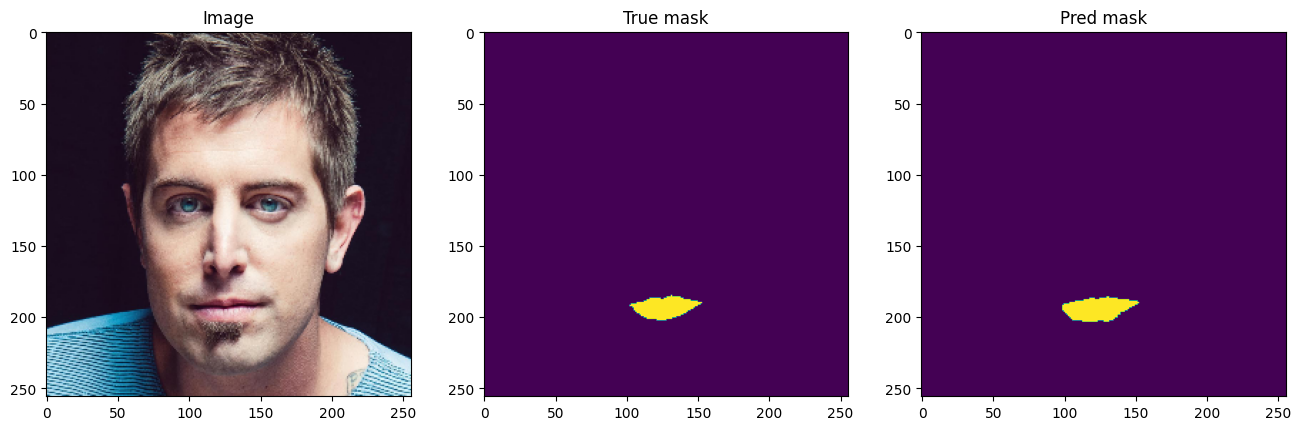

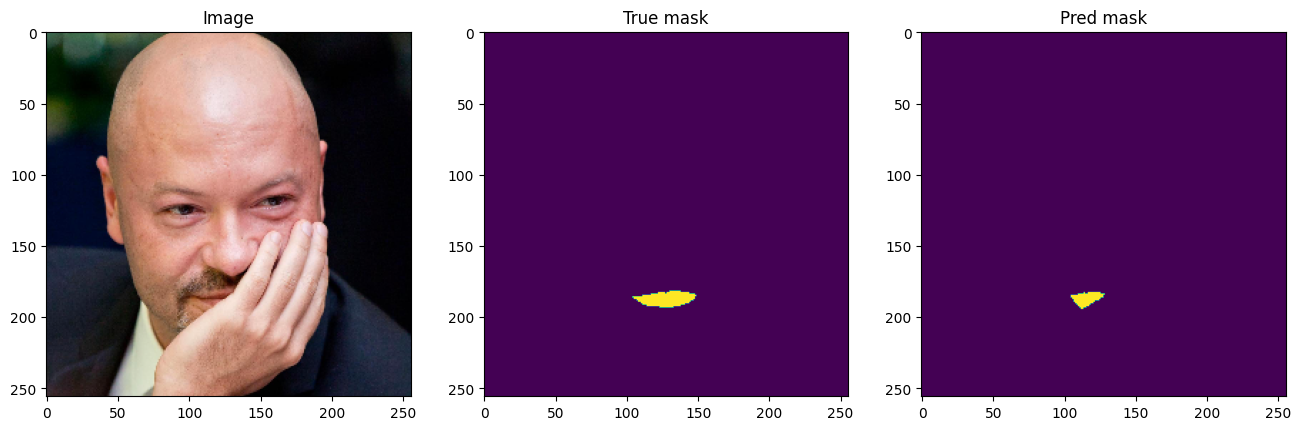

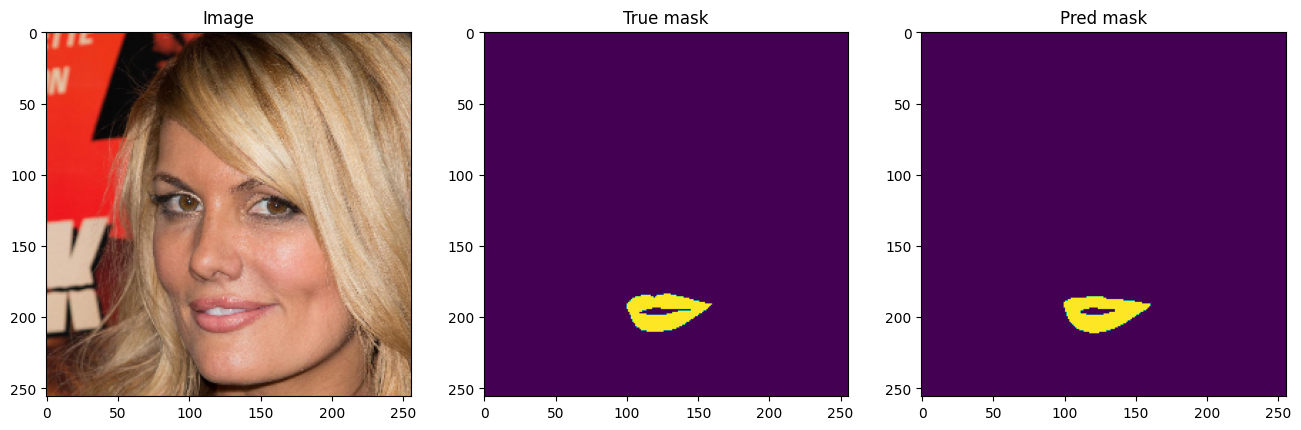

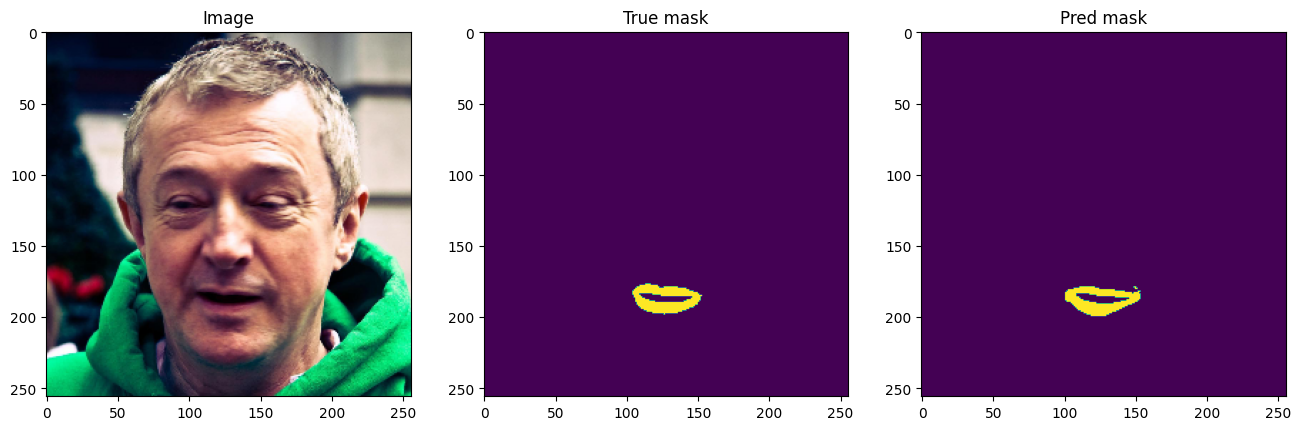

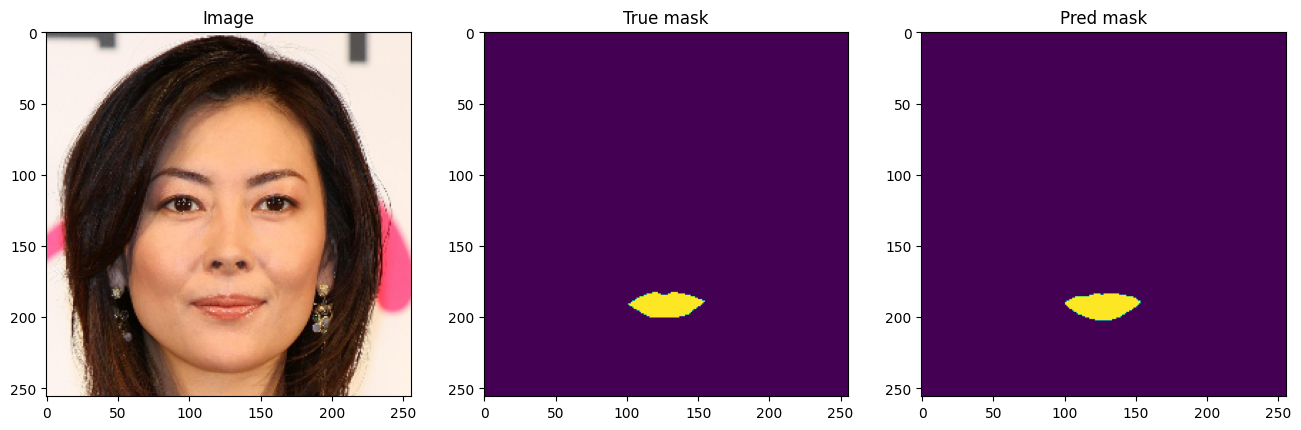

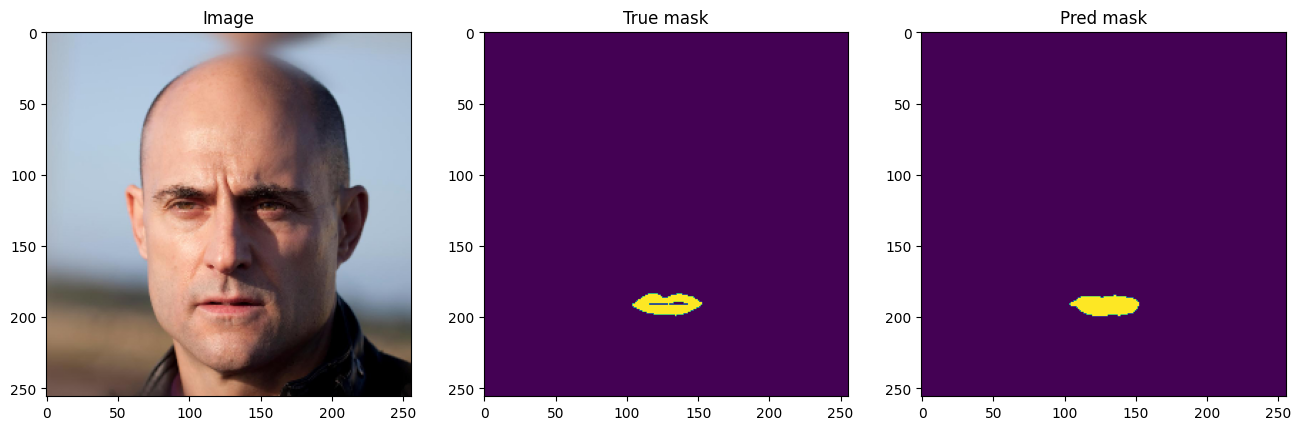

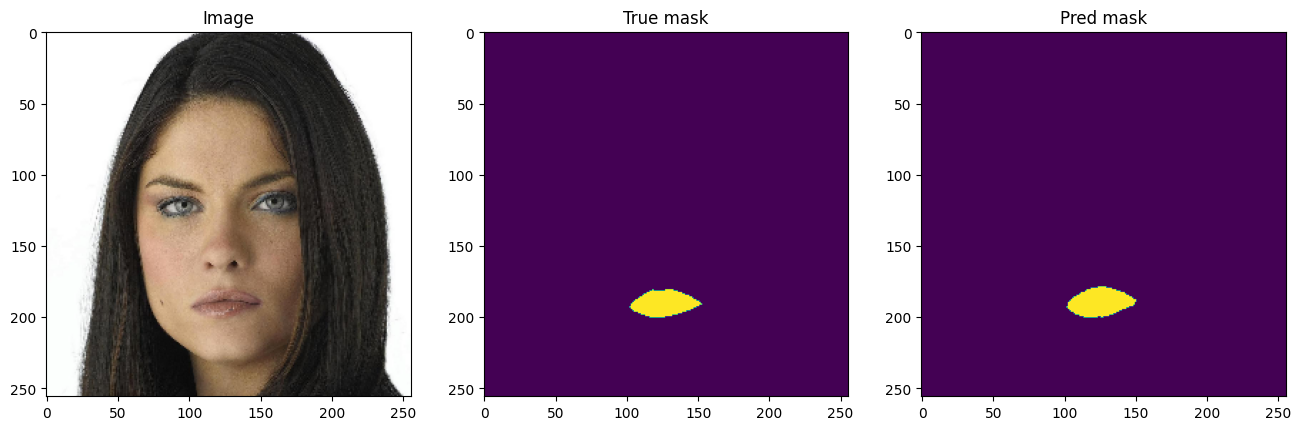

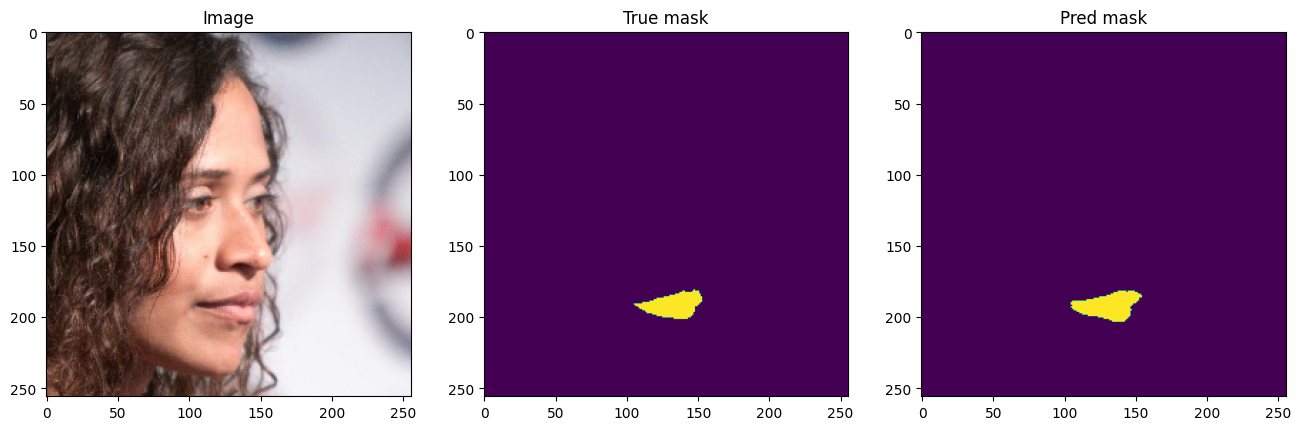

In [8]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')

    pred = predictions.detach().cpu()[i, ].permute(1, 2, 0)
    pred_mask = (pred > 0.5).float()
    ax_3.imshow(pred_mask)
    ax_3.set_title('Pred mask')

In [43]:
def test_with_metrics(model_path, test_loader, device):
    model = UNET()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    iou = torchmetrics.JaccardIndex(num_classes=2, task="binary").to(device)
    recall = torchmetrics.Recall(num_classes=2, task="binary").to(device)
    accuracy = torchmetrics.Accuracy(num_classes=2, task="binary").to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            preds = torch.sigmoid(model(images))
            
            iou.update(preds, labels)
            recall.update(preds, labels)
            accuracy.update(preds, labels)
    
    avg_iou = iou.compute()
    avg_recall = recall.compute()
    avg_accuracy = accuracy.compute()

    return avg_iou, avg_recall, avg_accuracy

In [44]:
avg_iou, avg_recall, avg_accuracy = test_with_metrics(r'C:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\own_models\model_10_epoch.pth', test_loader, DEVICE)

print(f'Srednie IOU: {avg_iou:.4f}')
print(f'Sredni Recall: {avg_recall:.4f}')
print(f'Srednie Accuracy: {avg_accuracy:.4f}')

C:\Users\aleks\AppData\Local\Temp\ipykernel_4316\3034429731.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Srednie IOU: 0.8221
Sredni Recall: 0.8925
Srednie Accuracy: 0.9976


## Testowanie na własnych danych i kamerce

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\aleks\AppData\Local\Temp\ipykernel_4316\3241327697.py:3: SyntaxWarning: invalid escape sequence '\m'
  print_prediction(f'C:\\Users\\aleks\\OneDrive\\Documents\\LIPS SEGMENTATION\\test_img\\test{i}.jpg', 'own_models\model_10_epoch.pth')
c:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\predict_file.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

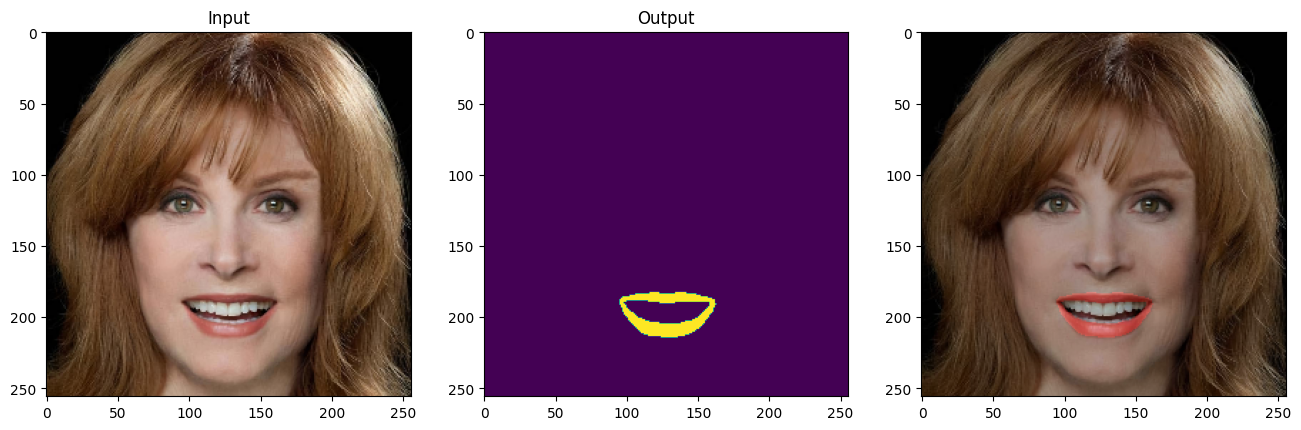

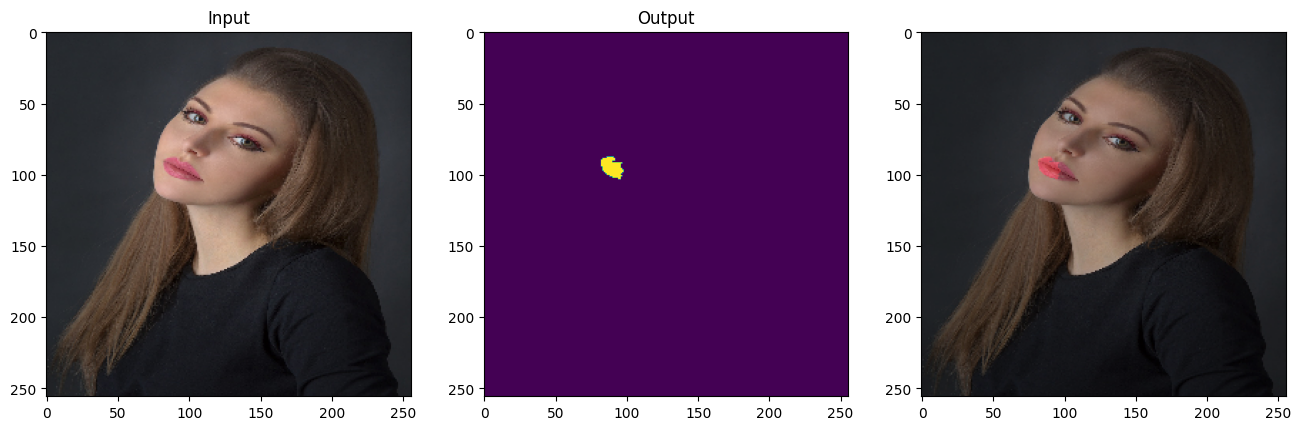

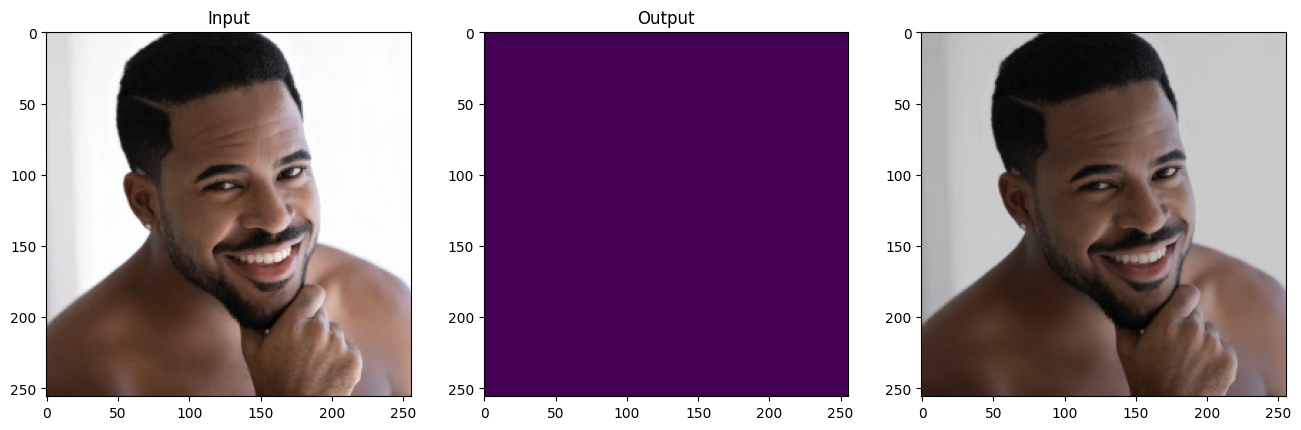

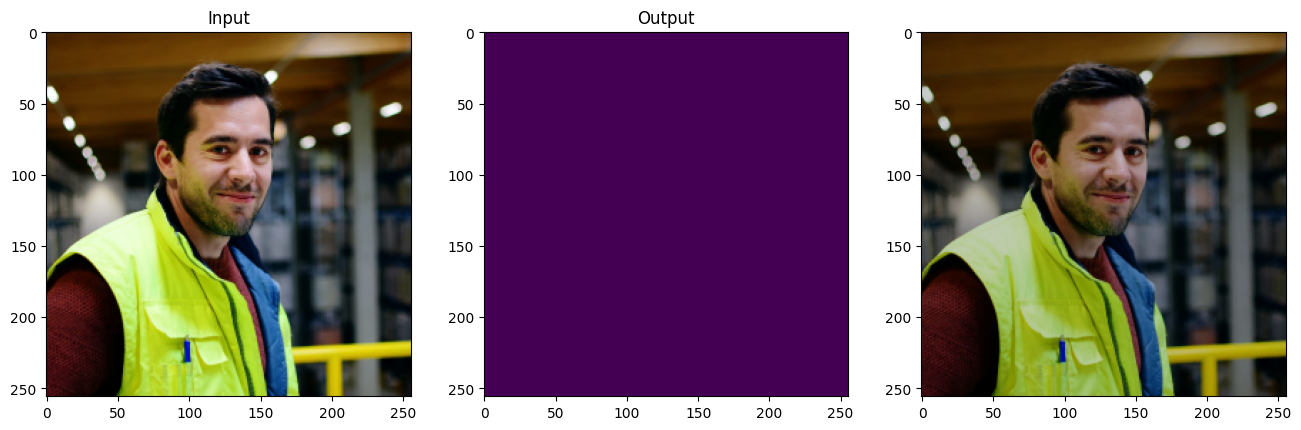

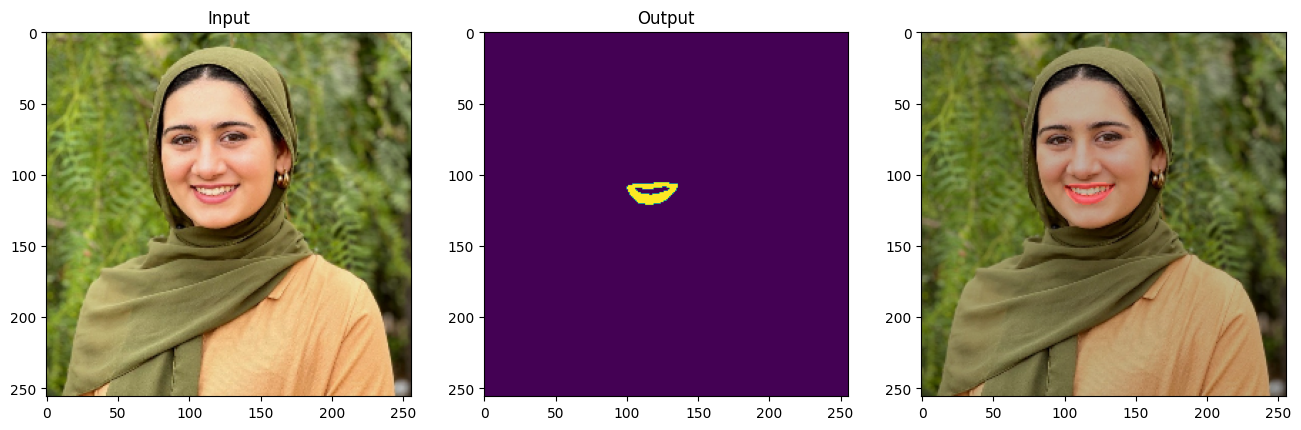

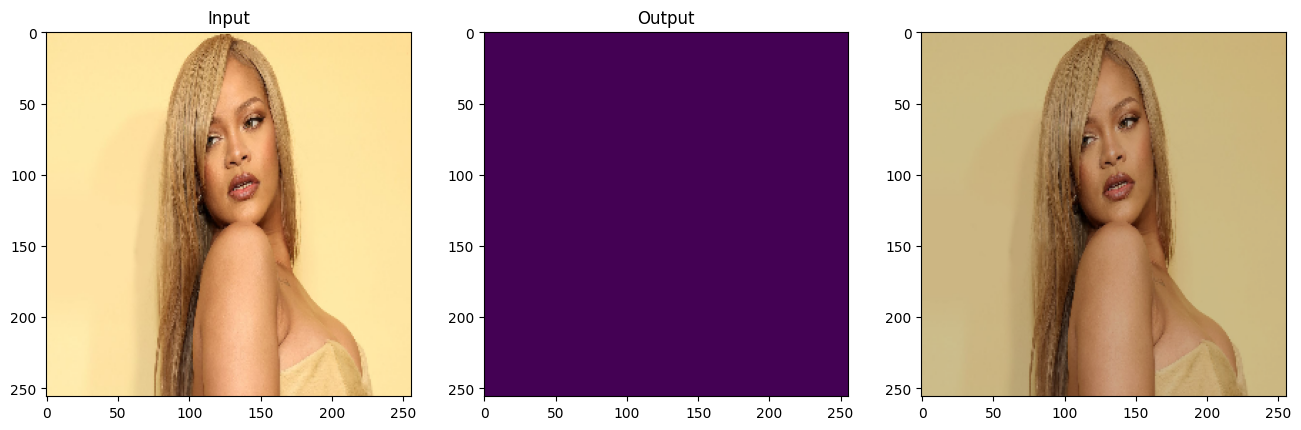

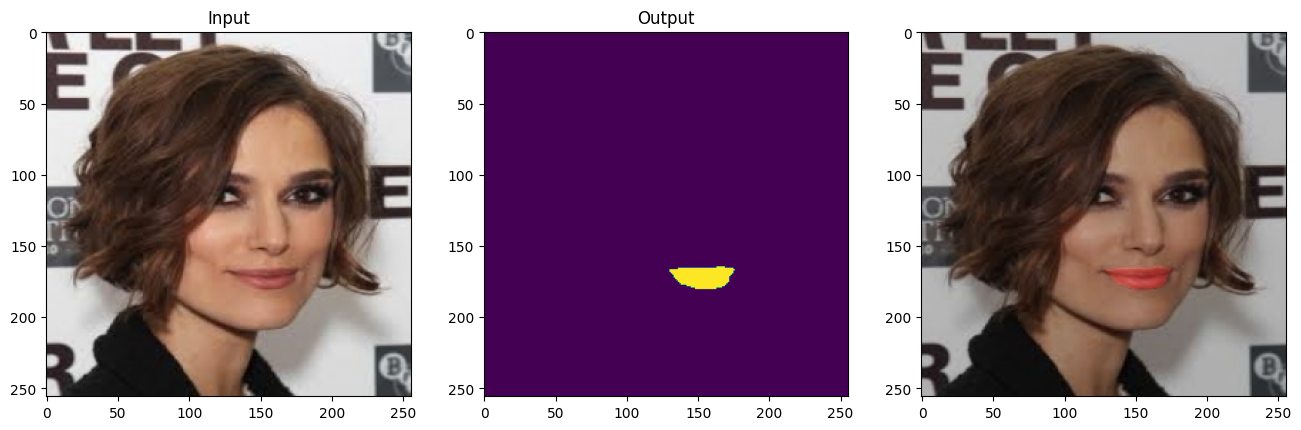

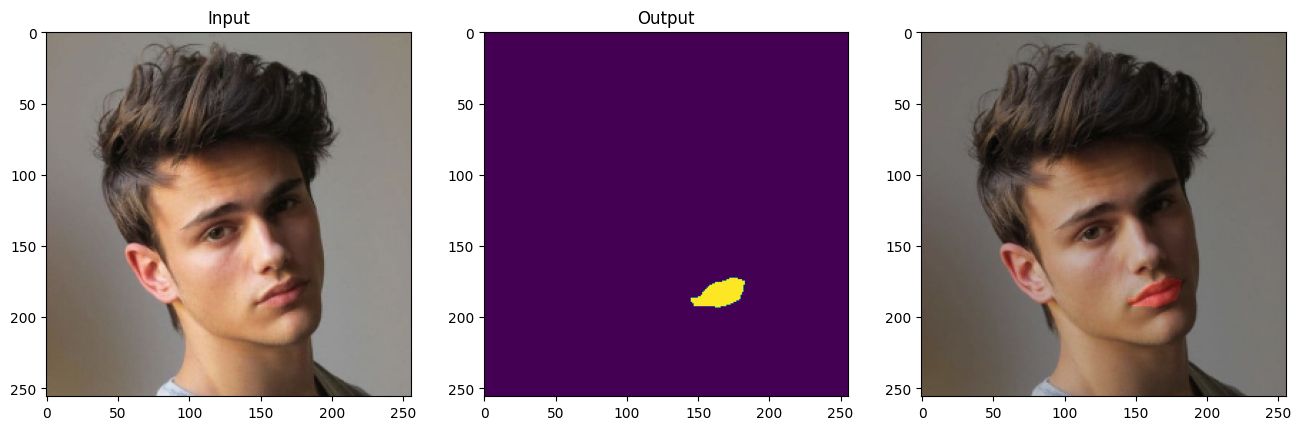

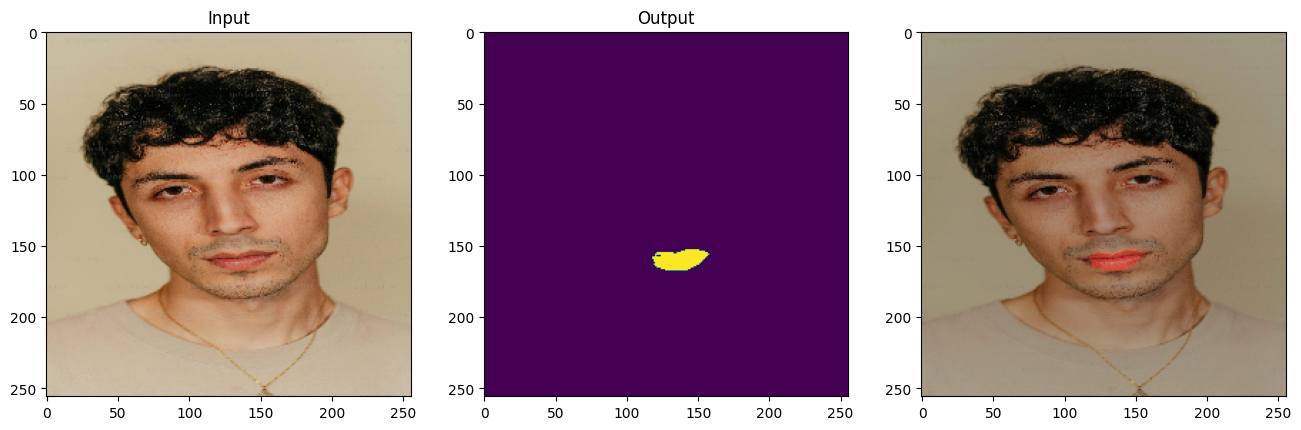

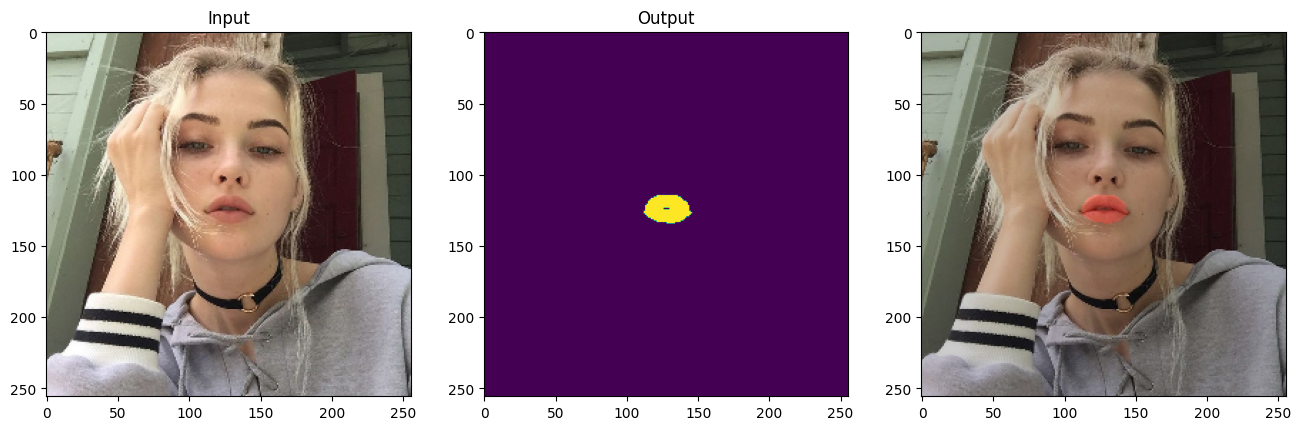

In [16]:
from predict_file import *
for i in range(10):
    print_prediction(f'C:\\Users\\aleks\\OneDrive\\Documents\\LIPS SEGMENTATION\\test_img\\test{i}.jpg', 'own_models\model_10_epoch.pth')

c:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\predict_file.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locati

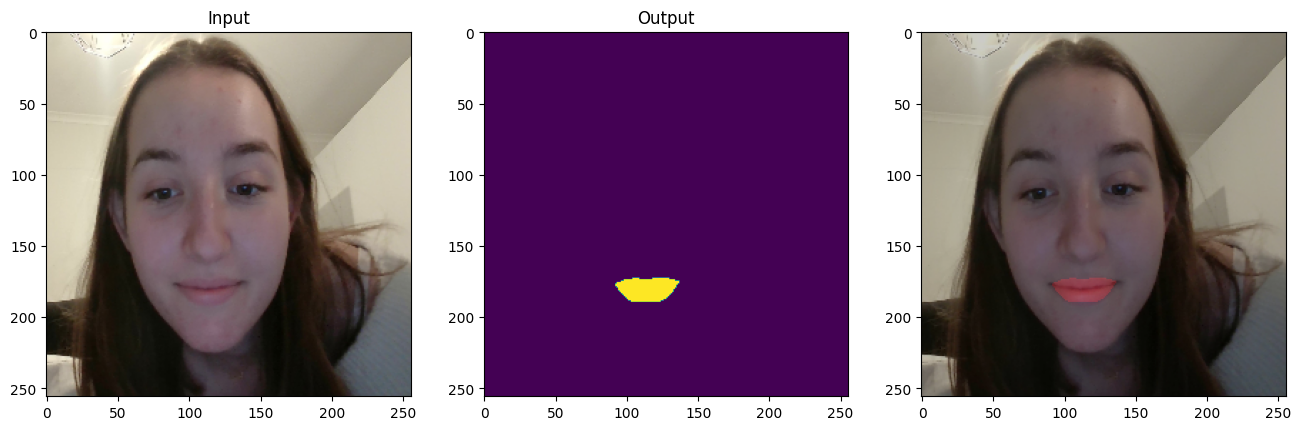

In [17]:
print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\Zrzut ekranu 2024-11-02 182839.png', r'C:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\own_models\model_10_epoch.pth')

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\aleks\AppData\Local\Temp\ipykernel_4316\1705761537.py:1: SyntaxWarning: invalid escape sequence '\m'
  print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_21_12_21_Pro.jpg', 'own_models\model_10_epoch.pth')
c:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\predict_file.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

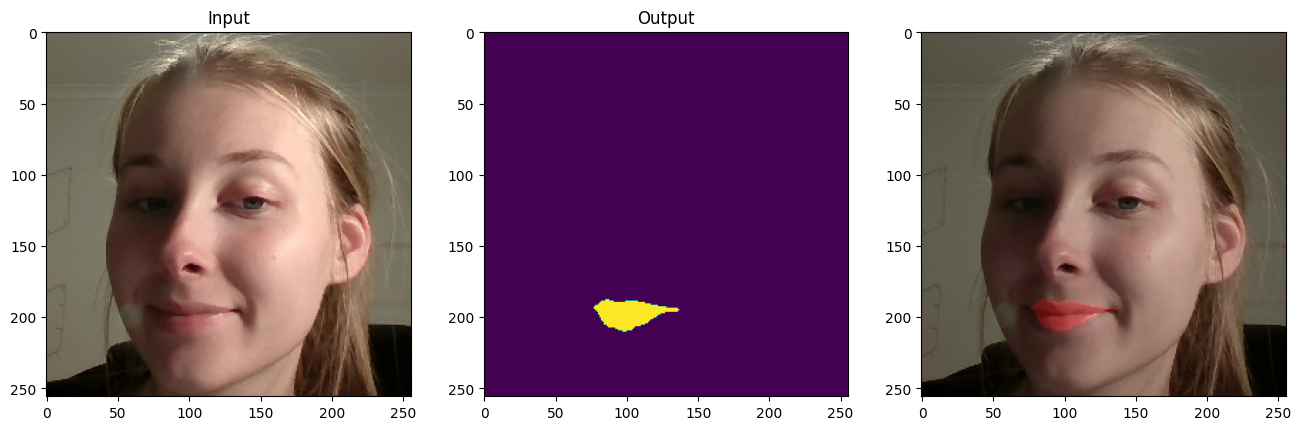

In [18]:
print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_21_12_21_Pro.jpg', 'own_models\model_10_epoch.pth')

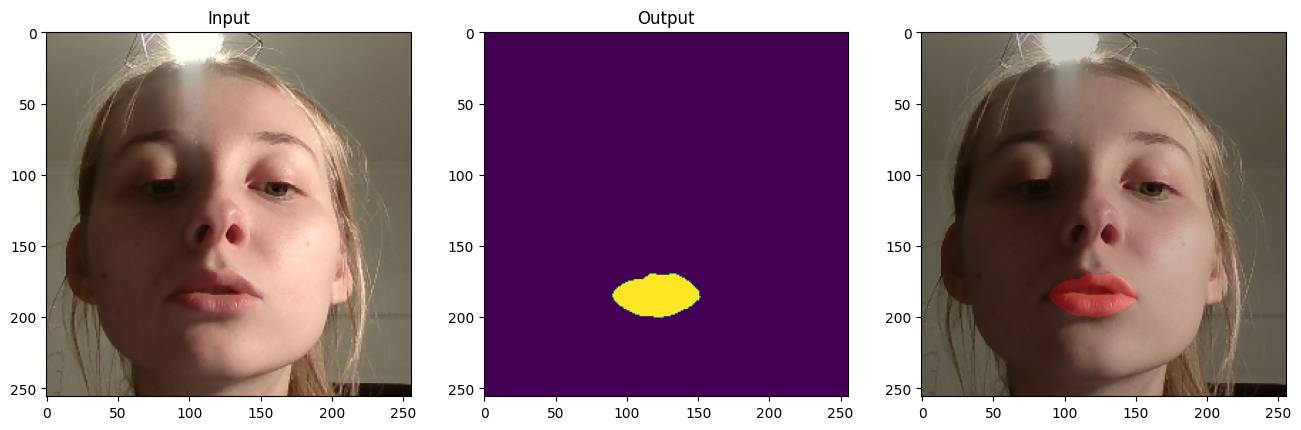

In [19]:
print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_21_12_34_Pro.jpg', r'C:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\own_models\model_10_epoch.pth')

In [20]:

def capture_mask_from_camer(model_path):
    camera = cv2.VideoCapture(0)

    desired_size = 256
    while True:
        ret,frame = camera.read()
        # Pobranie wymiarów obrazu
        height, width = frame.shape[:2]

        # Obliczenie współrzędnych ramki 256x256 na środku obrazu
        x_start = (width - desired_size) // 2
        y_start = (height - desired_size) // 2
        x_end = x_start + desired_size
        y_end = y_start + desired_size

        # Narysowanie ramki na podglądzie
        cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

        cv2.imshow("Podgląd z kamery", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):
            cropped_frame = frame[y_start:y_end, x_start:x_end]
            cv2.imwrite('zdjecie.png', cropped_frame)
            print('Zdjecie zapisane')
        elif key == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

    print_prediction(r'zdjecie.png', model_path)

Zdjecie zapisane


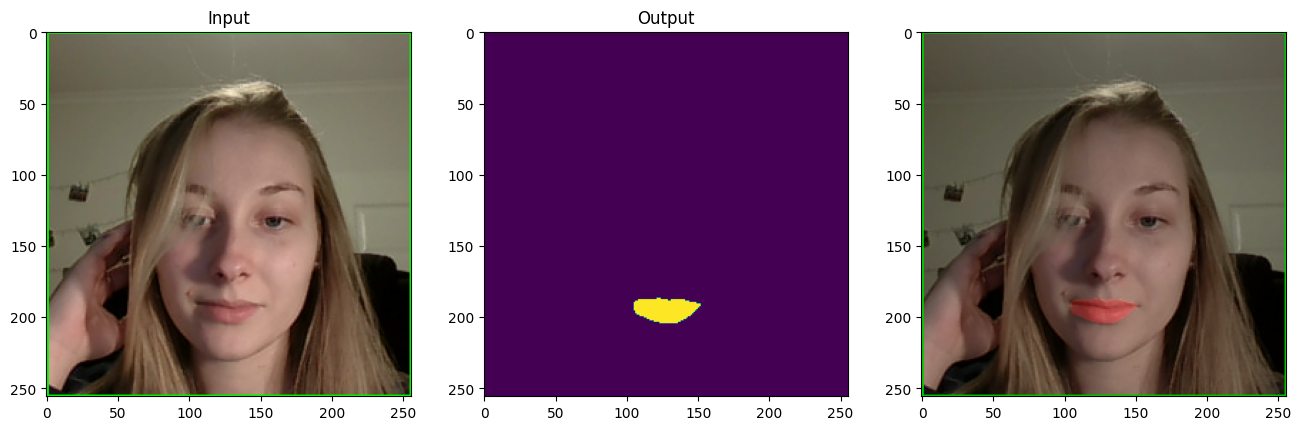

In [23]:
capture_mask_from_camer(r'C:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\own_models\model_10_epoch.pth')